Reference:
* Bootstrap sampling applied to image analysis
* [Hu moment in OpenCV](https://www.learnopencv.com/shape-matching-using-hu-moments-c-python/)

In [1]:
using Images, TestImages, Colors # load image
using Random, Distributions # normal etc
using Plots # basic plot
using ImageFiltering
using Random, Distributions
using Printf

using ImageSegmentation
using Random
using LinearAlgebra

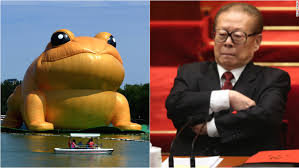

In [2]:
img = load("toad_and_jiang.jpg") # require package `ImageMagick`, 
#related to some shit problems: https://github.com/JuliaIO/ImageMagick.jl/issues/133

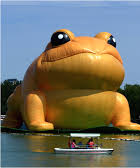

In [3]:
simg = img[1:size(img,1),1:140]

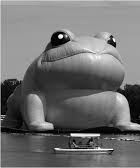

In [4]:
toad = Gray.(simg)

In [85]:
# I know that there're many redundancy computation. But
# premature optimization is the root of all evil

function hu_M(arr,i,j)
    # arr: [[ii_1,jj_1,I_1],[ii_2,jj_2,I_2],...]
    return sum(arr[:,1].^i .* arr[:,2].^j .* arr[:,3])
end

function hu_mu(arr,i,j)
    M00 = hu_M(arr, 0, 0)
    M10 = hu_M(arr, 1, 0)
    M01 = hu_M(arr, 0, 1)
    
    x_bar = M10/M00
    y_bar = M01/M00
    
    return sum((arr[:,1].-x_bar).^i .* (arr[:,2].-y_bar).^j .* arr[:,3])
end

function hu_eta(arr, i, j)
    mu00 = hu_mu(arr, 0, 0)
    return hu_mu(arr, i, j)/mu00^((i+j)/2+1)
end

function hu_hu(arr)
    eta20 = hu_eta(arr, 2, 0)
    eta02 = hu_eta(arr, 0, 2)
    eta11 = hu_eta(arr, 1, 1)
    eta12 = hu_eta(arr, 1, 2)
    eta21 = hu_eta(arr, 2, 1)
    eta30 = hu_eta(arr, 3, 0)
    eta03 = hu_eta(arr, 0, 3)
    
    mu03 = hu_mu(arr, 0, 3)
    
    hu1 = eta20+eta02
    hu2 = (eta20-eta02)^2 + 4*eta11^2
    #hu3 = (eta30-3*eta12)^2 + (3*eta21-mu03)^2
    #hu4 = (eta30+eta12)^2 + (eta21+mu03)^2
    hu3 = (eta30-3*eta12)^2 + (3*eta21-eta03)^2
    hu4 = (eta30+eta12)^2 + (eta21+eta03)^2
    hu5 = (eta30-3*eta12)*(eta30+eta12)*((eta30+eta12)^2-3*(eta21+eta03)^2) + (3*eta21-eta03)*(eta21+eta03)*(3*(eta30+eta12)^2-(eta21+eta03)^2)
    hu6 = (eta20-eta02)*((eta30+eta12)^2-(eta21+eta03)^2)+4*eta11*(eta30+eta12)*(eta21+eta03)
    hu7 = (3*eta21-eta03)*(eta30+eta12)*((eta30+eta12)^2-3*(eta21+eta03)^2)-(eta30-3*eta12)*(eta21+eta03)*(3*(eta30+eta12)^2-(eta21+eta03))
    return [hu1,hu2,hu3,hu4,hu5,hu6,hu7]
end

hu_hu (generic function with 1 method)

In [86]:
IJI_arr = zeros(prod(size(toad)), 3)

for i in 1:size(toad,1)
    for j in 1:size(toad,2)
        idx = (i-1)*size(toad,2)+j
        IJI_arr[idx,1] = i
        IJI_arr[idx,2] = j
        IJI_arr[idx,3] = toad[i,j]
    end
end

In [87]:
size(IJI_arr)

(23520, 3)

In [88]:
IJI_arr[1:5,:]

5×3 Array{Float64,2}:
 1.0  1.0  0.890196
 1.0  2.0  0.756863
 1.0  3.0  0.752941
 1.0  4.0  0.780392
 1.0  5.0  0.776471

In [89]:
hu_M(IJI_arr,1,1)

5.5848498964705884e7

In [90]:
hu_mu(IJI_arr,1,1)

818525.240650807

In [91]:
hu_eta(IJI_arr,1,1)

0.007621735069615235

In [92]:
hu_hu(IJI_arr)

7-element Array{Float64,1}:
 0.3992827655162117   
 0.0057626119262236455
 0.0023228973168189287
 0.002208385724667927 
 3.892849854566733e-6 
 0.0001395202263626585
 7.060881377753598e-6 

In [93]:
log.(hu_hu(IJI_arr))

7-element Array{Float64,1}:
  -0.9180854275869763
  -5.15636444764216  
  -6.064940029003845 
  -6.11549347168145  
 -12.456369058133477 
  -8.877300975366142 
 -11.860940673209532 

In [94]:
IJI_arr_255 = copy(IJI_arr)
IJI_arr_255[:,3] *= 255
hu_hu(IJI_arr_255)

7-element Array{Float64,1}:
 0.0015658147667302427 
 8.862148291001379e-8  
 1.4009075343986417e-10
 1.331847162655636e-10 
 1.4158804033547694e-20
 3.2997151478610955e-14
 5.755372431661896e-17 

Comparing Python OpenCV:

```
moments = cv2.moments(toad)
huMoments = cv2.HuMoments(moments)

array([[ 1.56579628e-03],
       [ 8.86281951e-08],
       [ 1.40100345e-10],
       [ 1.33194012e-10],
       [ 1.41611004e-20],
       [ 3.30017736e-14],
       [-1.14242293e-20]])
```

It seems correct.

and left-top result:
```
array([[1.09256394e-03],
       [4.83178828e-08],
       [3.51588466e-13],
       [6.47986624e-14],
       [9.60769908e-27],
       [7.32622785e-19],
       [1.83102143e-27]])
```

In [95]:
log.(hu_hu(IJI_arr_255))

7-element Array{Float64,1}:
  -6.459348972745402
 -16.238891537959013
 -22.688730664479124
 -22.739284107156738
 -45.70395032908406 
 -31.04235515599986 
 -37.393812826368446

In [96]:
n_sample = 100
mat = zeros(n_sample,7)
for t=1:n_sample
    N = prod(size(toad))
    n= N
    p = rand(1:n, n)
    mat[t,:] = log.(hu_hu(IJI_arr_255[p,:]))
end

In [97]:
mean(mat,dims=1)

1×7 Array{Float64,2}:
 -6.45866  -16.2351  -22.6948  -22.7399  -45.711  -31.0371  -37.4237

In [98]:
std(mat,dims=1)

1×7 Array{Float64,2}:
 0.00553497  0.0516113  0.0785514  0.0441947  0.111981  0.0573556  0.210073

In [99]:
n_sample = 100
mat = zeros(n_sample,7)
for t=1:n_sample
    N = prod(size(toad))
    n= N
    p = rand(1:n, n)
    mat[t,:] = log.(hu_hu(IJI_arr_255[p,:]))
end

In [100]:
mean(mat,dims=1)

1×7 Array{Float64,2}:
 -6.45864  -16.23  -22.6873  -22.739  -45.706  -31.0351  -37.4158

In [101]:
std(mat,dims=1)

1×7 Array{Float64,2}:
 0.00558762  0.0455014  0.0789312  0.0529716  0.117658  0.0682049  0.240466

In [102]:
n_sample = 100
mat = zeros(n_sample,7)
for t=1:n_sample
    N = prod(size(toad))
    n= Int(floor(N / 10))
    p = rand(1:N, n)
    #println((N/n)*hu_hu(IJI_arr_255[p,:]))
    mat[t,:] = log.((N/n)*hu_hu(IJI_arr_255[p,:]))
end

In [103]:
mean(mat,dims=1)

1×7 Array{Float64,2}:
 -1.85146  -9.30161  -13.4775  -13.5331  -29.6393  -19.549  -24.8829

In [104]:
std(mat,dims=1)

1×7 Array{Float64,2}:
 0.0176964  0.152336  0.251252  0.16016  0.377079  0.251157  0.798269

In [105]:
n_sample = 100
mat = zeros(n_sample,7)
for t=1:n_sample
    N = prod(size(toad))
    n= Int(floor(N / 10))
    p = rand(1:N, n)
    mat[t,:] = log.((N/n)*hu_hu(IJI_arr_255[p,:]))
end

In [106]:
mean(mat,dims=1)

1×7 Array{Float64,2}:
 -1.85374  -9.3402  -13.4691  -13.5427  -29.6277  -19.5589  -24.9108

In [107]:
std(mat,dims=1)

1×7 Array{Float64,2}:
 0.01575  0.160223  0.230296  0.171559  0.399147  0.2373  0.825005

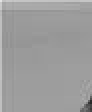

In [108]:
lefttop = toad[1:Int(div(size(toad,1),3)), 1:Int(div(size(toad,2),3))]

In [111]:
function get_arr(toad)
    IJI_arr = zeros(prod(size(toad)), 3)

    for i in 1:size(toad,1)
        for j in 1:size(toad,2)
            idx = (i-1)*size(toad,2)+j
            IJI_arr[idx,1] = i
            IJI_arr[idx,2] = j
            IJI_arr[idx,3] = toad[i,j]
        end
    end
    
    IJI_arr[:,3] *= 255
    return IJI_arr
end

function get_mat(IJI_arr; n_sample = 100, factor = 1)
    mat = zeros(n_sample,7)
    for t=1:n_sample
        N = size(IJI_arr, 1)
        n= Int(floor(N / factor))
        p = rand(1:N, n)
        mat[t,:] = (N/n)*hu_hu(IJI_arr[p,:])
    end
    return mat
end

get_mat (generic function with 3 methods)

In [114]:
log.(get_mat(get_arr(lefttop), factor=1)[:,1:4])

100×4 Array{Float64,2}:
 -6.82368  -16.9366  -27.0629  -30.5185
 -6.84061  -16.8815  -28.1616  -28.4578
 -6.80115  -16.7136  -27.6899  -28.0879
 -6.84281  -17.0215  -27.4272  -28.4899
 -6.82231  -16.8655  -26.9779  -28.0109
 -6.82364  -16.9168  -28.2203  -31.0033
 -6.81353  -16.8366  -27.7373  -27.358 
 -6.8385   -16.9212  -28.9787  -27.5096
 -6.81054  -16.8564  -29.1603  -29.1358
 -6.83478  -16.97    -26.6548  -27.467 
 -6.81258  -16.8919  -26.6768  -27.3864
 -6.81793  -17.0367  -26.1498  -29.7672
 -6.83038  -16.8616  -29.0179  -28.0996
  ⋮                                    
 -6.79662  -16.6842  -27.8154  -29.3869
 -6.82845  -16.8312  -28.1285  -28.994 
 -6.79126  -16.6018  -29.8824  -29.0733
 -6.81441  -16.8523  -25.9964  -28.8455
 -6.80548  -16.8542  -30.6031  -30.6828
 -6.81649  -16.6421  -27.6049  -29.633 
 -6.80881  -16.8257  -28.4782  -29.5056
 -6.83633  -16.8473  -31.1567  -29.8639
 -6.8307   -16.6817  -26.6075  -27.6016
 -6.82464  -16.8636  -27.342   -29.0164
 -6.82288  -16.8

In [116]:
mean(log.(get_mat(get_arr(lefttop), factor=1)[:,1:4]), dims=1)

1×4 Array{Float64,2}:
 -6.81822  -16.8551  -27.8066  -29.0998

In [117]:
std(log.(get_mat(get_arr(lefttop), factor=1)[:,1:4]), dims=1)

1×4 Array{Float64,2}:
 0.0136614  0.122563  1.41982  1.30956

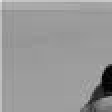

In [129]:
s = Int(div(size(toad,1),3))
lefttop = toad[1:s, 1:s]


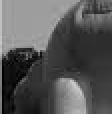

In [130]:
leftcenter = toad[s:s*2,1:s]


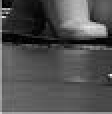

In [131]:
leftbottom  =toad[s*2:s*3,1:s]

In [143]:
function extract_hu4(patch)
    return log.(get_mat(get_arr(patch), factor=1)[:,1:4])
end

function extract_hu4_det(patch)
    return hu_hu(get_arr(patch))
end

extract_hu4_det (generic function with 1 method)

In [144]:
lefttop_hu = extract_hu4(lefttop)
leftcenter_hu = extract_hu4(leftcenter)
leftbottom_hu = extract_hu4(leftbottom)
;

In [145]:
mean(lefttop_hu, dims=1),std(lefttop_hu, dims=1)

([-6.8294 -19.0398 -25.6155 -29.337], [0.0125297 0.513629 0.552982 1.31383])

In [146]:
mean(leftcenter_hu, dims=1),std(leftcenter_hu, dims=1)

([-6.22848 -15.0614 -21.3032 -22.2034], [0.0156342 0.125875 0.156363 0.190716])

In [147]:
mean(leftbottom_hu, dims=1),std(leftbottom_hu, dims=1)

([-6.13634 -15.4188 -21.7003 -23.955], [0.0115904 0.167924 0.210781 0.283237])

In [148]:
log.(extract_hu4_det(lefttop)[1:4])

4-element Array{Float64,1}:
  -6.8294471219240656
 -19.129161412492994 
 -25.568368931487676 
 -30.647451085939892 

In [149]:
log.(extract_hu4_det(leftcenter)[1:4])

4-element Array{Float64,1}:
  -6.2285704128372466
 -15.068614704364027 
 -21.29280810416969  
 -22.184275042976726 

In [150]:
log.(extract_hu4_det(leftbottom)[1:4])

4-element Array{Float64,1}:
  -6.135696454516388
 -15.384917064725064
 -21.72958861347641 
 -23.9696596103768  

In [151]:
mean(extract_hu4(lefttop),dims=1)

1×4 Array{Float64,2}:
 -6.82861  -19.1743  -25.5872  -29.1389

In [152]:
mean(extract_hu4(leftcenter),dims=1)

1×4 Array{Float64,2}:
 -6.23016  -15.0695  -21.3074  -22.2108

In [153]:
mean(extract_hu4(leftbottom),dims=1)

1×4 Array{Float64,2}:
 -6.13593  -15.3992  -21.7643  -23.889

In [154]:
std(extract_hu4(lefttop),dims=1)

1×4 Array{Float64,2}:
 0.0116114  0.498883  0.588154  1.15163

In [155]:
std(extract_hu4(leftcenter),dims=1)

1×4 Array{Float64,2}:
 0.0173645  0.136977  0.144501  0.183392

In [156]:
std(extract_hu4(leftbottom),dims=1)

1×4 Array{Float64,2}:
 0.0126118  0.196901  0.221381  0.245768

In [157]:
mean(extract_hu4(lefttop) .- extract_hu4(leftcenter), dims=1)

1×4 Array{Float64,2}:
 -0.599284  -4.04262  -4.23923  -7.19135

In [158]:
std(extract_hu4(lefttop) .- extract_hu4(leftcenter), dims=1)

1×4 Array{Float64,2}:
 0.0194806  0.494082  0.446417  0.902237

In [160]:
mean(extract_hu4(leftcenter) .- extract_hu4(leftbottom), dims=1)

1×4 Array{Float64,2}:
 -0.0930093  0.324531  0.460017  1.72703

In [161]:
std(extract_hu4(leftcenter) .- extract_hu4(leftbottom), dims=1)

1×4 Array{Float64,2}:
 0.020551  0.226595  0.271722  0.312929

In [162]:
mean(sum((extract_hu4(leftcenter) .- extract_hu4(leftbottom)).^2,dims=2), dims=1)

1×1 Array{Float64,2}:
 3.4878584149691942

In [163]:
std(sum((extract_hu4(lefttop) .- extract_hu4(leftcenter)).^2,dims=2), dims=1)

1×1 Array{Float64,2}:
 1.1309244158062466

In [164]:
mean(sum((extract_hu4(lefttop) .- extract_hu4(leftcenter)).^2,dims=2), dims=1)

1×1 Array{Float64,2}:
 88.30492743385149

In [165]:
std(sum((extract_hu4(lefttop) .- extract_hu4(leftcenter)).^2,dims=2), dims=1)

1×1 Array{Float64,2}:
 17.829461200792306

In [168]:
seg = 3
si = Int(div(size(toad,1), seg))
sj = Int(div(size(toad,2), seg))
f_mat = zeros(seg, seg, 100, 4)
for i in 1:seg
    for j in 1:seg
        patch = toad[1+(i-1)*si:i*si,1+(j-1)*sj:j*sj]
        f_mat[i,j,:,:] = extract_hu4(patch)
        #dis = sum((extract_hu4(leftcenter) .- extract_hu4(leftbottom)).^2,dims=2)
    end
end

In [169]:
using PyPlot

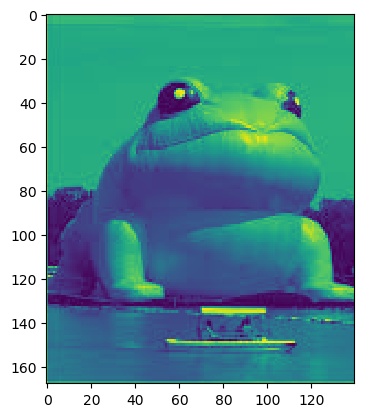

PyObject <matplotlib.image.AxesImage object at 0x0000000039298860>

In [173]:
imshow(convert(Array{Float64}, toad))

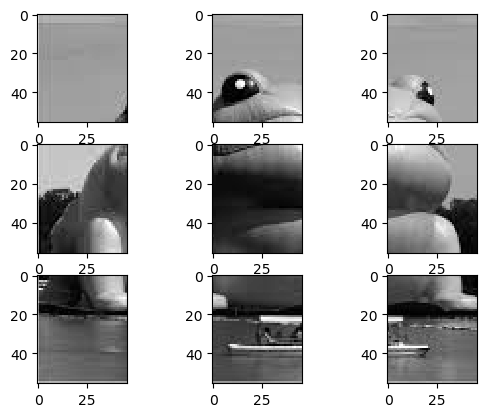

In [181]:
fig, axs = subplots(seg,seg)
for i=1:seg
    for j=1:seg
        patch = toad[1+(i-1)*si:i*si,1+(j-1)*sj:j*sj]
        axs[i,j].imshow(convert(Array{Float64}, patch), cmap="gray")
    end
end

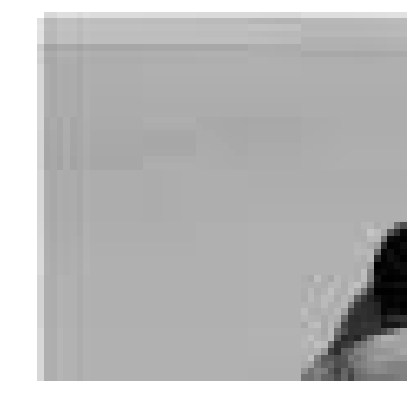

(-0.5, 55.5, 55.5, -0.5)

In [184]:
imshow(convert(Array{Float64}, lefttop), cmap="gray")
axis("off")

In [197]:
#=
for i=1:seg
    for j=1:seg
        patch = toad[1+(i-1)*si:i*si,1+(j-1)*sj:j*sj]
        imshow(convert(Array{Float64}, patch), cmap="gray")
        axis("off")
        PyPlot.savefig("images/toad_$(i)_$(j).png")
        clf()
    end
end
=#

In [233]:
#println("start")
for i=1:seg
    for j=1:seg
        if (j+1<=seg)
            d = sum((f_mat[i,j,:,:] .- f_mat[i,j+1,:,:]).^2,dims=2)
            mean_d = @sprintf("%.3f",mean(d))
            std_d = @sprintf("%.3f",std(d))
            #println("\\draw [-] (toad_$(i)_$(j).east) -- (toad_$(i)_$(j+1).west) node [midway, bwlow] {\$ $(mean_d)")
            println("\\draw [-] (toad_$(i)_$(j).east) -- (toad_$(i)_$(j+1).west) node [midway, below] {\$ $(mean_d) \\pm $(std_d) \$};")
        end
        if (i+1<=seg)
            d = sum((f_mat[i,j,:,:] .- f_mat[i+1,j,:,:]).^2,dims=2)
            mean_d = @sprintf("%.3f",mean(d))
            std_d = @sprintf("%.3f",std(d))
            #println("\\draw")
            println("\\draw [-] (toad_$(i)_$(j).south) -- (toad_$(i+1)_$(j).north) node [midway, left] {\$ $(mean_d) \\pm $(std_d) \$};")
        end
    end
end


\draw [-] (toad_1_1.east) -- (toad_1_2.west) node [midway, below] {$ 24.988 \pm 22.369 $};
\draw [-] (toad_1_1.south) -- (toad_2_1.north) node [midway, left] {$ 117.053 \pm 42.209 $};
\draw [-] (toad_1_2.east) -- (toad_1_3.west) node [midway, below] {$ 16.502 \pm 11.726 $};
\draw [-] (toad_1_2.south) -- (toad_2_2.north) node [midway, left] {$ 14.012 \pm 3.556 $};
\draw [-] (toad_1_3.south) -- (toad_2_3.north) node [midway, left] {$ 44.610 \pm 17.570 $};
\draw [-] (toad_2_1.east) -- (toad_2_2.west) node [midway, below] {$ 8.931 \pm 3.148 $};
\draw [-] (toad_2_1.south) -- (toad_3_1.north) node [midway, left] {$ 2.160 \pm 0.927 $};
\draw [-] (toad_2_2.east) -- (toad_2_3.west) node [midway, below] {$ 3.937 \pm 2.340 $};
\draw [-] (toad_2_2.south) -- (toad_3_2.north) node [midway, left] {$ 5.036 \pm 7.379 $};
\draw [-] (toad_2_3.south) -- (toad_3_3.north) node [midway, left] {$ 1.577 \pm 1.423 $};
\draw [-] (toad_3_1.east) -- (toad_3_2.west) node [midway, below] {$ 10.723 \pm 10.646 $};
\dr

In [201]:
println("\$")

$


In [205]:
println("[-]")

[-]


In [209]:
println("\\draw [-] ")

\draw [-] 


In [228]:
sprintf

UndefVarError: UndefVarError: sprintf not defined

In [235]:
1 + 
 2

3